In [1]:
from library import *
from dataset_creation import *
from k_fold import *

In [2]:
def plot_color(values, size=(30,5), coef=1):
    
    my_cmap = plt.get_cmap('copper')
    my_norm = plt.Normalize(vmin=0, vmax=max(values)*coef)
    colormap=my_cmap(my_norm(values))
    
    return colormap

# Logistic Regression

In [10]:
clf = LogisticRegression(solver="liblinear")

In [11]:
clf.fit(X_train, y_train)
y_LR = clf.predict(X_test)

NameError: name 'X_train' is not defined

In [ ]:
mat = confusion_matrix(y_test, y_LR)

sns.set(font_scale=1.5) 
sns.heatmap(mat, square = True, annot=True, cbar=False, fmt="d")
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
accuracy_score(y_test, y_LR)

In [ ]:
y_LR

# NAIVE BAYES

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
y_pred = clf.fit(X_train, y_train)
y_MNB = clf.predict(X_test)

mat = confusion_matrix(y_test, y_MNB)

sns.set(font_scale=1.5) 
sns.heatmap(mat, square = True, annot=True, cbar=False, fmt="d")
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
accuracy_score(y_test, y_MNB)

# GNB

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train)
y_GNB = gnb.predict(X_test)

mat = confusion_matrix(y_test, y_GNB)

sns.set(font_scale=1.5) 
sns.heatmap(mat, square = True, annot=True, cbar=False, fmt="d")
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
accuracy_score(y_test, y_GNB)

# K-fold

In [ ]:
def apply_Logistic_Regression(X_tr, y_tr, X_te):
    clf = LogisticRegression(random_state=0)
    clf.fit(X_tr, y_tr)
    y_LR = clf.predict(X_te)
    return y_LR

best combination (ACC: -0.463): (0, 1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16)



/tmp/ipykernel_14120/2860798908.py:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  acc = float((y_res == y_pred).sum()) / y_pred.shape[0]


AttributeError: 'bool' object has no attribute 'sum'

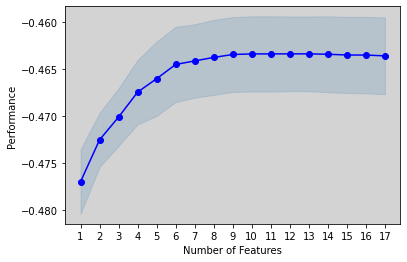

In [34]:
for k in range(3, 11):
    
    kfold = StratifiedKFold(n_splits=k, random_state=123, shuffle=True)
    
    for lambda_ in [0.01, 0.1, 1, 10, 100]
        
        for grado in [1,2,3]
        
                LR = LogisticRegression(solver = 'newton-cg', C = lambbda_, grad0 = grado)
    

                sfs = SFS(LR, 
                      k_features=(3,17), 
                      forward=True, 
                      floating=False, 
                      scoring='neg_log_loss',
                      cv= kfold)
        
                .
                .
                .

                array.append(risultato)
            
            

    .
    .
    .
    .


# K-FOLD CROSS VALIDATION
# using X_train and y_train as new dataset to split in X_train_new + X_validation
sfs = sfs.fit(X_res, y_res)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
#X.iloc[:,list(sfs.k_feature_idx_) ]

X_train_sfs = sfs.transform(X_res)
X_test_sfs = sfs.transform(X_big_array)
3
# Fit the estimator using the new feature subset
# and make a prediction on the test data
LR.fit(X_train_sfs, y_res)
y_pred = LR.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_res == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

In [42]:
(y_res == y_pred)

numpy.ndarray

In [44]:
y_pred.shape

(5109,)